In [1]:
import math
import numpy as np
from numpy.random import *
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib
import enum
import itertools
from functools import * 
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
#ABM

S = 0
I = 1
R = 2


class Agent:
    def __init__(self, width, height, state):
        self.x = random()*width
        self.y = random()*height
        self.state = state
        
    def __repr__(self):
        return repr((self.x, self.y, self.state))
    
    
def dist(a1,a2):
    return np.linalg.norm([a1.x - a2.x, a1.y - a2.y])


def plot_sir(s,i,r, legend=["S", "I", "R"]):
    T = np.size(s)
    plt.plot(range(T), s)
    plt.plot(range(T), i)
    plt.plot(range(T), r)
    plt.legend(legend)

#sigma for diffusion, ci contact intensity, function of distance
class ABM: 

    def __init__(self, n, I0, l, theta, mu, sigma, ci):
        self.agents = [Agent(l,l, S if i >= I0 else I) for i in range(n)]
        self.n_I = I0
        self.n_S = n - I0
        self.n_R = 0
        self.s = [self.n_S/n]
        self.i = [self.n_I/n]
        self.r = [self.n_R/n]
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.ci = ci
        self.side = l
        
    def get_pos(self, state=None):
        if state == None:
            return np.array([[a.x, a.y] for a in self.agents])
        else:
            return np.array([[a.x, a.y] for a in self.agents if a.state == state])
    

    def update_counts(self, nI_change, nR_change):
        self.n_I += nI_change - nR_change
        self.n_S -= nI_change
        self.n_R += nR_change
    
    def update_state(self):
        for a in self.agents:
            if a.state == S:
                total_ci = reduce(lambda p_sum, a1: p_sum + (self.ci(a,a1) if a1.state == I and a1 != a else 0), self.agents, 0)
                if random() < 1 - np.exp(-total_ci*self.theta):
                    a.state = I
                    self.update_counts(1, 0)
            elif a.state == I:
                if random() < 1 - np.exp(-self.mu):
                    a.state = R
                    self.update_counts(0, 1)
                    
    def update_pos(self):
        for a in self.agents:
            a.x = (a.x + normal(0, self.sigma)) % self.side
            a.y = (a.y + normal(0, self.sigma)) % self.side
            
    def update(self):
        self.update_state()
        self.update_pos()
        self.s.append(self.n_S/n)
        self.i.append(self.n_I/n)
        self.r.append(self.n_R/n)
    
    def sim(self, T):
        for t in range(T-1):
            self.update()
        return self.s,self.i,self.r



In [57]:
def run_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, beta=None):
    s0,i0,r0 = np.zeros(T), np.zeros(T), np.zeros(T)
    s,i,r = np.zeros(T), np.zeros(T), np.zeros(T)
    if beta is None:
        beta = compute_beta(n,l,theta)
    
    for t in range(iterations):
        abm = ABM(n, I0, l, theta, mu, sigma, ci)
        s_temp, i_temp, r_temp = abm.sim(T)
        s0 += np.array(s_temp)/iterations
        i0 += np.array(i_temp)/iterations
        r0 += np.array(r_temp)/iterations

    i[0] = I0/n
    s[0] = 1 - i[0]
    r[0] = 0

    for t in range(T-1):
        i[t+1] = i[t] + beta*s[t]*i[t] - mu*i[t]
        r[t+1] =  r[t] + mu*i[t]
        s[t+1] = 1 - r[t] - i[t]
        
    return s,i,r,s0,i0,r0,beta


    
def print_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, s, i, r, s0, i0, r0, beta):
    print("Simulation with n: {}, l: {}, I0: {}, theta: {}, mu: {}, sigma: {}, T: {}".format(n,l,I0,theta, mu, sigma, T))
    print("The computed beta for the ODE is: {}".format(round(beta,3)))
    print("The average error across s,i,r over {} iterations is: {}".format(iterations,
                                                                            round(sum((i0 - i)**2 + (s0 - s)**2 + (r0 - r)**2)/(3*T),5)))
    plot_sir(s0,i0,r0)
    plot_sir(s, i, r, legend=["S_ABM", "I_ABM", "R_ABM","S_ODE", "I_ODE", "R_ODE"])
    plt.show()
    
def compute_beta(n, l, theta):
    integral = integrate.nquad(lambda x,y: np.exp(-0.005*(x-y)*(x-y)), [[0, l], [0, l]])[0]
    return n*theta*(integral**2)/(l**4)


Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 1, T: 100
The computed beta for the ODE is: 0.053
The average error across s,i,r over 50 iterations is: 0.011


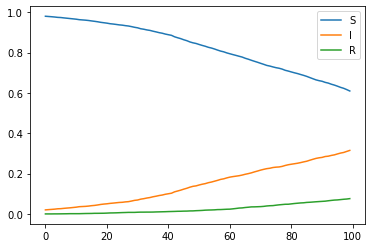

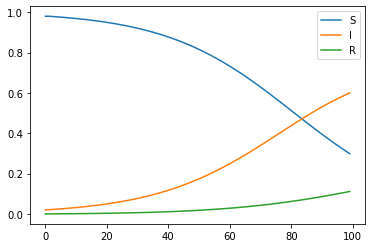

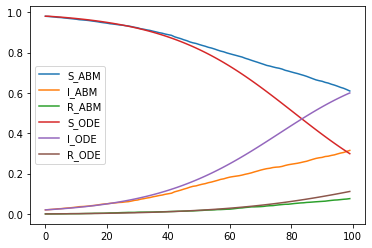

In [25]:
l = 100
n = 100
I0 = 2
T = 100
theta = 0.01
mu = 0.005
sigma = 1
ci = lambda a1,a2: np.exp(-0.005*((a1.x - a2.x)**2 + (a1.y - a2.y)**2))
s,i,r,s0,r0,i0,beta = run_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations)
print_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, s, i, r, s0, r0, i0, beta)

# Parameters

$n$ is the number of agents, $l$ the side of the box, $I_0$ the initial number of infected agents, $T$ the simulation teps, $\theta$ is an agent-to-agent infection rate (to be multiplied by a contact intensity which takes into account distance), $\mu$ is the ricovery rate, $ci$ is the contact intensity, function of the positions of the two agents, and $\sigma$ is standard-deviation of the diffusion process.

For the ODE, $\mu$ is the same and the infection rate is $\beta$, computed from the ABM by averaging

The $ci$ I am using is always $ci(x,y) = e^{-\lambda(x-y)^2}$ for some constant $\lambda$, because integrating it is very fast

# Computations:

In the following cells we explore some aspects of the parameter space, starting with the impact of $\sigma$ and $n$.
As a measure of the goodness of the ODE approximation, we compute the total error defined as the $L_2$ distance $|| (S_{ABM}, I_{ABM}, R_{ABM}) - (S_{ODE}, I_{ODE}, R_{ODE})||_2$, where $(S_{ABM}, I_{ABM}, R_{ABM})$ is average across the specified number of iterations (here it's 50)

# Varying $\sigma$

Here we choose $n = 50, l = 100, I_0 = 2, \theta = 0.01, \mu = 0.05,  ci(x,y) = e^{-\lambda(x-y)^2}$ and vary $\sigma$ to be 0, 1, 5 or 50, and we repeat the experiment in the following cell with $n = 100$, and with $n = 300$ in the cell after that.

As expected, the same ABM model produces vastly different results when varying the timescale of mobility (which in this case is a simple diffusion, controlled by $\sigma$). The computation of $\beta$ does not reflect this, because it completely ignores the mobility process and just does a spatial average that does not include any time component, and thus the ODE results are identical regardless of $\sigma$. 
The ODE results approximate the ABM results better and better for increasing $\sigma$, but in general they overestimate the speed of the infection, i.e. we mostly observe $I_{ODE} > I_{ABM}$. This is probably due to the fact that, when the diffusion is slow, clusters of infected agents form in the ABM, and the overall infection rate is then lower than for a well-mixed distribution of infected agents, because agents in the cluster cannot infect each other. For high $\sigma$, the correlation between neighboring agents' states is small, and this effect less impactful (the mean field assumption becomes justified)
  


Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 0, T: 100
The computed beta for the ODE is: 0.027
The average error across s,i,r over 50 iterations is: 0.00093


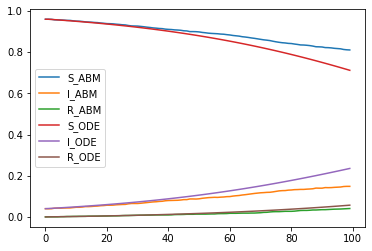

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 1, T: 100
The computed beta for the ODE is: 0.027
The average error across s,i,r over 50 iterations is: 0.0006


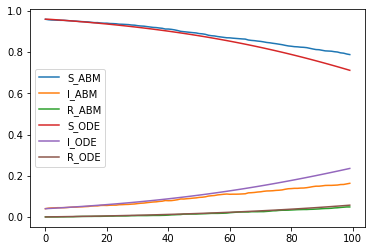

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 5, T: 100
The computed beta for the ODE is: 0.027
The average error across s,i,r over 50 iterations is: 3e-05


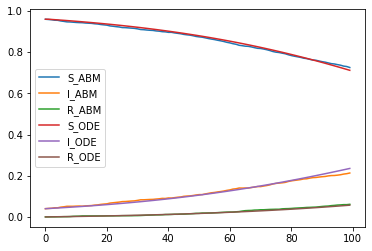

Simulation with n: 50, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 50, T: 100
The computed beta for the ODE is: 0.027
The average error across s,i,r over 50 iterations is: 9e-05


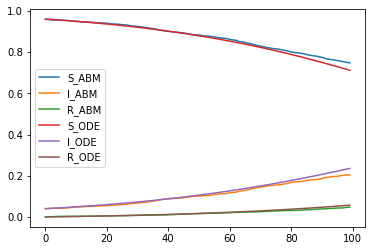

In [37]:
#n = 50 varying sigma
n = 50

l = 100
I0 = 2
T = 100
theta = 0.01
mu = 0.005
ci = lambda a1,a2: np.exp(-0.005*((a1.x - a2.x)**2 + (a1.y - a2.y)**2))

sigmas = [0, 1, 5, 50]
for sigma in sigmas:
    beta = compute_beta(n,l,theta)
    print_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, *run_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations,beta))

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 0, T: 100
The computed beta for the ODE is: 0.053
The average error across s,i,r over 50 iterations is: 0.01325


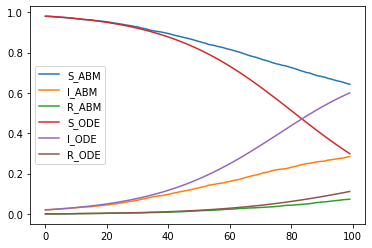

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 1, T: 100
The computed beta for the ODE is: 0.053
The average error across s,i,r over 50 iterations is: 0.00951


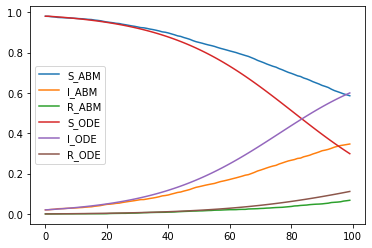

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 5, T: 100
The computed beta for the ODE is: 0.053
The average error across s,i,r over 50 iterations is: 0.00283


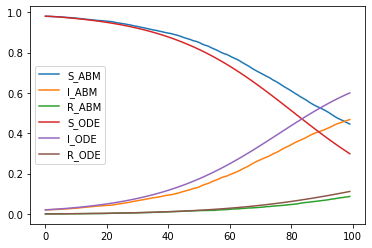

Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 50, T: 100
The computed beta for the ODE is: 0.053
The average error across s,i,r over 50 iterations is: 0.00021


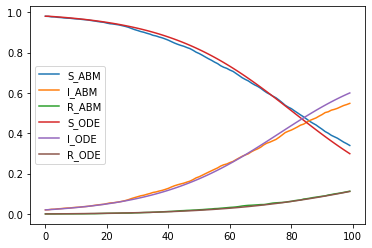

In [36]:
#n = 100, varying sigma
n = 100
for sigma in sigmas:
    beta = compute_beta(n,l,theta)
    print_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, *run_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations,beta))

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 0, T: 100
The computed beta for the ODE is: 0.16
The average error across s,i,r over 50 iterations is: 0.01427


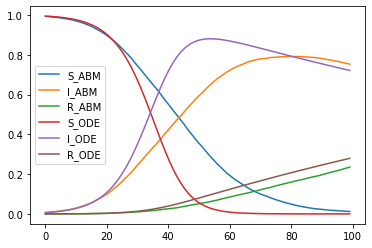

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 1, T: 100
The computed beta for the ODE is: 0.16
The average error across s,i,r over 50 iterations is: 0.0084


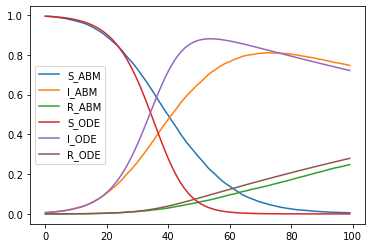

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 5, T: 100
The computed beta for the ODE is: 0.16
The average error across s,i,r over 50 iterations is: 0.00158


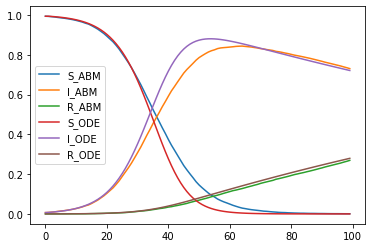

Simulation with n: 300, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 50, T: 100
The computed beta for the ODE is: 0.16
The average error across s,i,r over 50 iterations is: 0.00044


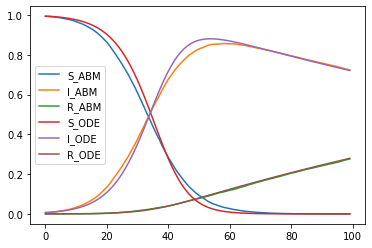

In [38]:
#n = 300, varying sigma
n = 300
for sigma in sigmas:
    beta = compute_beta(n,l,theta)
    print_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, *run_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations,beta))

# Two competing effects: clustering induced error and small population error

In the following cell, we look at the error more systematically, plotting it for many values of $n$ at once for each of the $\sigma$ values we tried before.
Generally speaking, we would expect large $n$ to yield better results, and this seems to be asymptotically true, but for intermediate values of $n$ the error tends to spike and then get much lower past a certain point.

This might be explainable by the effect of $n$ on clustering. For very low $n$, there is barely any clustering of infected agents because there is barely any clustering of agents in general. As $n$ increases, clusters of infected agents can form more easily, making the ODE overestimate the speed of infection. Eventually, the effect of clustering is superseded by the positive effect of having a large population,  

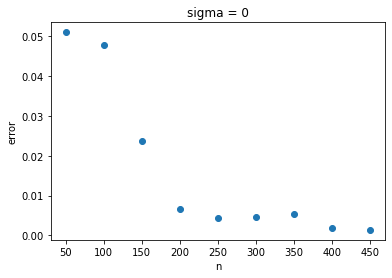

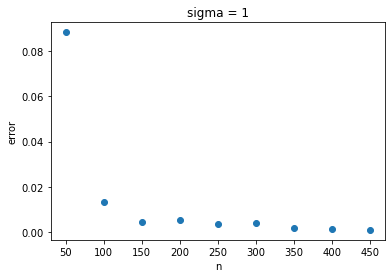

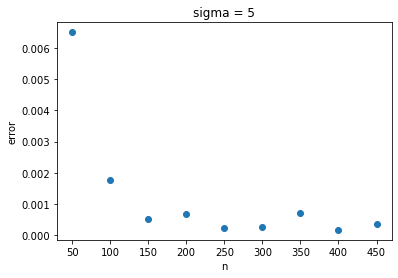

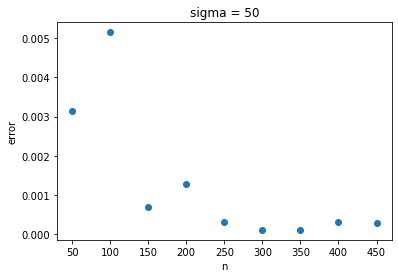

In [92]:
ns = [j*50 for j in range(1, 10)]
error = np.zeros((len(ns), len(sigmas)))
T = 500
iterations = 10
for counter1, sigma in enumerate(sigmas):
    for counter, n in enumerate(ns):
        beta = compute_beta(n,l,theta)
        s, i, r, s0, i0, r0, _ = run_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, beta)
        error[counter, counter1] = sum((i0 - i)**2 + (s0 - s)**2 + (r0 - r)**2)/(3*T)
    
    plt.figure()
    plt.title("sigma = {}".format(sigma))
    plt.scatter(ns, error[:, counter1])
    plt.xlabel("n")
    plt.ylabel("error")
    plt.show()

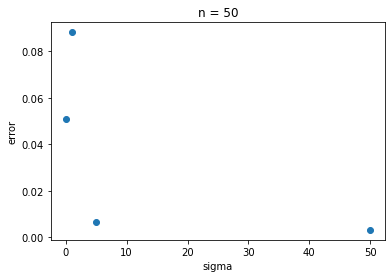

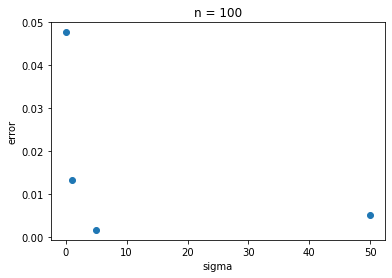

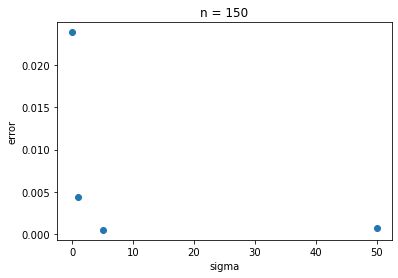

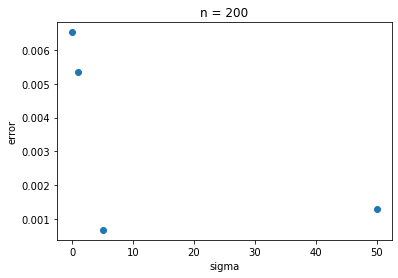

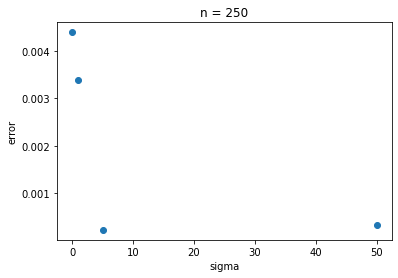

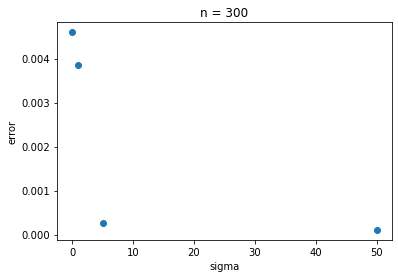

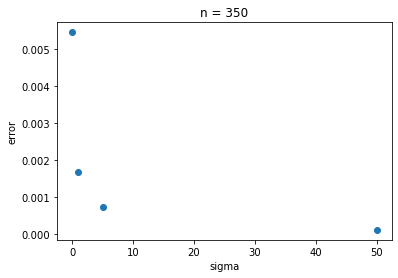

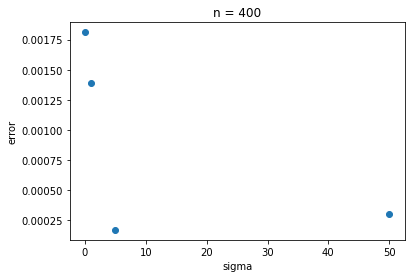

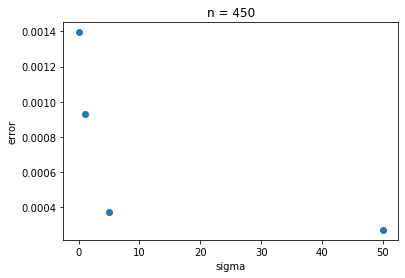

In [94]:
for counter, n in enumerate(ns):
    plt.figure()
    plt.scatter(sigmas, error[counter, :])
    plt.xlabel("sigma")
    plt.ylabel("error")
    plt.title("n = {}".format(n))
    plt.show()

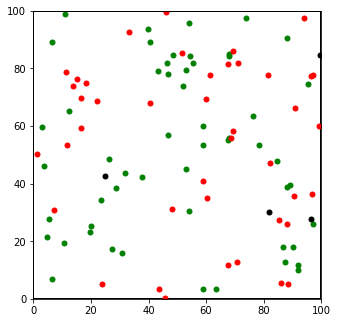

In [52]:
%matplotlib inline
sigma = 3
n = 100
l = 100
abm = ABM(n, I0, l, theta, mu, sigma, ci)
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(0, l), ylim=(0, l))

agents_S, = ax.plot([], [], 'go', ms=6)
agents_I, = ax.plot([], [], 'ro', ms=6)
agents_R, = ax.plot([], [], 'ko', ms = 6)

# rect is the box edge
rect = plt.Rectangle([0,0],l, l,
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global rect
    agents_S.set_data([], [])
    agents_I.set_data([], [])
    agents_R.set_data([], [])
    rect.set_edgecolor('none')
    return agents_S, agents_I, agents_R, rect

def animate(i):
    """perform animation step"""
    global abm, rect, ax, fig
    abm.update()
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    pos_S = abm.get_pos(S)
    pos_I = abm.get_pos(I)
    pos_R = abm.get_pos(R)
    if pos_S.size > 0:
        agents_S.set_data(pos_S[:, 0], pos_S[:, 1])
        agents_S.set_markersize(5)
    else:
        agents_S.set_data([], [])
    if pos_I.size > 0:
        agents_I.set_data(pos_I[:, 0], pos_I[:, 1])
        agents_I.set_markersize(5)
    else:
        agents_I.set_data([], [])
    if pos_R.size > 0:
        agents_R.set_data(pos_R[:, 0], pos_R[:, 1])
        agents_R.set_markersize(5)
    else:
        agents_R.set_data([], [])
    return agents_S, agents_I, agents_R, rect

anim = animation.FuncAnimation(fig, animate, frames=100,
                              interval=250, blit=True, init_func=init)


rc('animation', html='html5')
anim


Simulation with n: 100, l: 100, I0: 2, theta: 0.01, mu: 0.005, sigma: 100, T: 100
The computed beta for the ODE is: 0.053
The average error across s,i,r over 10 iterations is: 0.00419


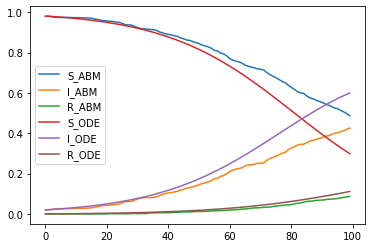

In [55]:
n = 100
iterations = 10
sigma = 100
beta = compute_beta(n,l,theta)
print_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, *run_experiment(n, I0, l, theta, mu, sigma, ci, T, iterations, beta))